# CNN + Transfer learning 練習

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

## Where AM I 資料讀入及前處理

In [145]:
pf_train = pd.read_csv('dataset/train.txt', header=None, sep=' ', names=['img_path', 'label'])

In [146]:
pf_valid = pd.read_csv('dataset/valid.txt', header=None, sep=' ', names=['img_path', 'label'])

In [147]:
print(pf_train.shape, pf_valid.shape)
pf_train.head(3)

(1020, 2) (1020, 2)


,img_path,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42


In [148]:
train_list = pf_train
test_list = pf_valid
data_list = pd.concat([pf_train,pf_valid], axis=0)

# from sklearn.model_selection import train_test_split

# train_list, test_list = train_test_split(data_list,
#                                          test_size=0.1,
#                                          random_state=42,
#                                          stratify=data_list['label'].values)

# 觀察訓練集的類別分布，每個類別都是10張圖片

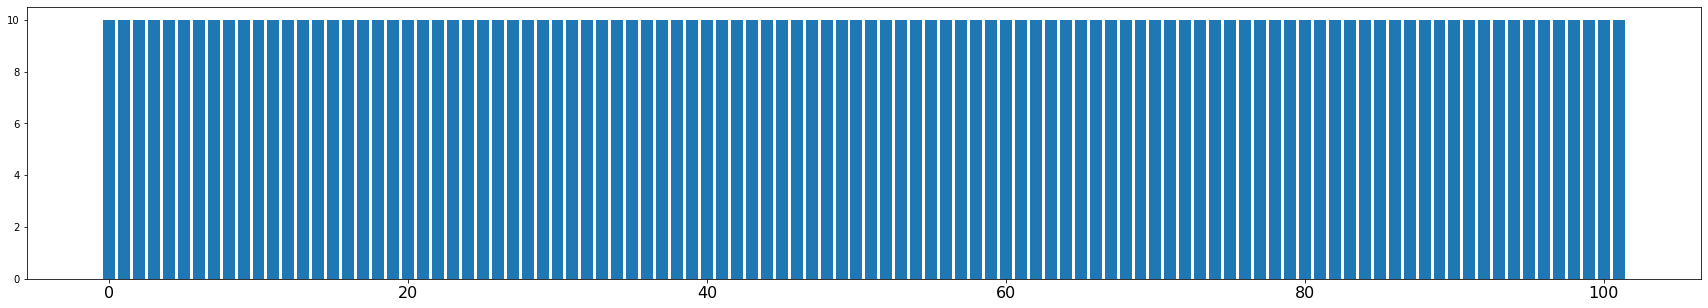

In [149]:
uniques, counts = np.unique(pf_train['label'], return_counts=True)

plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [150]:
counts

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

# 把label轉成字串(原來是int64)

In [151]:
train_list['label'] = train_list['label'].astype(str)
test_list['label'] = test_list['label'].astype(str)

In [152]:
train_list

,img_path,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96
...,...,...
1015,jpg/image_02944.jpg,59
1016,jpg/image_07434.jpg,93
1017,jpg/image_02684.jpg,57
1018,jpg/image_01639.jpg,81


In [77]:
img_size = 224
num_class = len(data_list['label'].unique())

## 讀入 Pre-trained Model

In [39]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [40]:
pre_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [42]:
# model.summary()

# 決定 Pre-Train 參數量

In [43]:
pre_model.trainable = True

# trainable_layer = 10
# for layer in pre_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [166]:
#model.summary()

In [44]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

In [110]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 20

In [111]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [112]:
data_path='dataset'
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

# 用在不知道 label 的資料讀取上
# test_generator = test_datagen.flow_from_dataframe(
#                                                     dataframe=test_list,
#                                                     directory=data_path,
#                                                     x_col="img_path",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode=None,
#                                                     shuffle=False)


Found 1020 validated image filenames belonging to 102 classes.
Found 1020 validated image filenames belonging to 102 classes.


## 開始訓練模型

In [113]:
model_dir = 'model-logs/resnet50'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [114]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/20
32/32 [==============================] - 33s 1s/step - loss: 1.7415 - accuracy: 0.7382 - val_loss: 1.9562 - val_accuracy: 0.6010
Epoch 2/20
32/32 [==============================] - 27s 829ms/step - loss: 1.5314 - accuracy: 0.7843 - val_loss: 1.7855 - val_accuracy: 0.6392
Epoch 3/20
32/32 [==============================] - 26s 817ms/step - loss: 1.3643 - accuracy: 0.8098 - val_loss: 1.6435 - val_accuracy: 0.6765
Epoch 4/20
32/32 [==============================] - 26s 820ms/step - loss: 1.1914 - accuracy: 0.8598 - val_loss: 1.5250 - val_accuracy: 0.7029
Epoch 5/20
32/32 [==============================] - 26s 824ms/step - loss: 1.0114 - accuracy: 0.8980 - val_loss: 1.4246 - val_accuracy: 0.7216
Epoch 6/20
32/32 [==============================] - 26s 818ms/step - loss: 0.8940 - accuracy: 0.9167 - val_loss: 1.3479 - val_accuracy: 0.7402
Epoch 7/20
32/32 [==============================] - 26s 827ms/step - loss: 0.7883 - accuracy: 0.9392 - val_loss: 1.2702 - val_accuracy: 0.7520
Ep

## 訓練結果視覺化

In [116]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

32/32 - 7s - loss: 0.8008 - accuracy: 0.8373


In [117]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [118]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5666666666666667
[[4 0 0 ... 0 0 0]
 [0 9 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 9 0 0]
 [0 0 0 ... 0 3 0]
 [1 0 0 ... 0 0 9]]


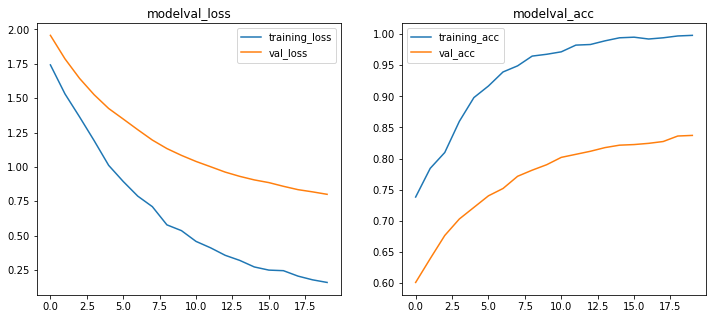

In [119]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()

# 開始考試
---

In [168]:
df_exam = pd.read_csv('dataset/test.txt', header=None, names=['img_path'])

In [169]:
df_exam[:3]

,img_path
0,jpg/image_06977.jpg
1,jpg/image_00800.jpg
2,jpg/image_05038.jpg


# 方法1: 用ImageDataGenerator
---

In [123]:
exam_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [125]:
exam_generator = exam_datagen.flow_from_dataframe(
                                                    dataframe=df_exam,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col=None,
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False)

Found 6149 validated image filenames.


In [127]:
y_pred_exam = model.predict_generator(exam_generator)
y_pred_exam = y_pred_exam.argmax(-1)
y_pred_exam

array([30, 81, 56, ..., 83, 75, 76])

In [129]:
df_exam['class'] = y_pred_exam

# 方法2: 用迴圈讀取圖片，再丟進模型預測
---

In [209]:
def loop_pred():
    y_pred_loop = []
    for filename in df_exam['img_path'].values:
        y_pred_loop.append(ans_pred('dataset/' + filename))
        
    return y_pred_loop

In [164]:
def ans_pred(img_path):
    #img = image.load_img('./dataset/jpg/image_00001.jpg', target_size=(224, 224))
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return model.predict(x).argmax()

In [185]:
# 測試預測一張圖片
ans_pred('dataset/jpg/image_06977.jpg')

30

In [179]:
#df_exam['class'] = loop_pred()

In [200]:
ans_map = inv_map = {v: k for k, v in class_name.items()}

In [205]:
df_exam['class'] = df_exam['class'].apply(lambda x: ans_map[x])

In [206]:
df_exam.rename(columns={'img_path': 'id'}).to_csv('answer.csv', index=False)

,img_path,class
0,jpg/image_06977.jpg,34
1,jpg/image_00800.jpg,80
2,jpg/image_05038.jpg,58
3,jpg/image_06759.jpg,0
4,jpg/image_01133.jpg,88
...,...,...
6144,jpg/image_08168.jpg,61
6145,jpg/image_07487.jpg,90
6146,jpg/image_04432.jpg,82
6147,jpg/image_02532.jpg,75
